# This is a place to test post-processing blocks. Not to run fem solver multiple times

In [2]:
import blocks as bl
import elementDefs as ed
import constants as cst
import copy
import numpy.typing as nt
import typing as ty
import numpy as np
import scipy.sparse as ss
import scipy.sparse.linalg as ssl
import scipy.optimize as opt

In [3]:
import pyfe3d as pf3
import pyfe3d.shellprop_utils as psp
import pyfe3Dgcl as p3g

quad = p3g.QuadWithProp(pf3.Quad4Probe())
quad.update_probe_finte(psp.isotropic_plate(E=200e9, nu=.3, thickness=.003))

In [4]:
'''Standard test setup'''
data = "5000;0;-6.5|4750;0;-24|4500;0;-41|4000;0;-75|3500;0;-107|3000;0;-138|2500;0;-167|2000;0;-190|1500;0;-206|1250;0;-211|1000;0;-211.5|750;0;-205|500;0;-187.5|375;0;-173|250;0;-150.5|125;0;-113.5|62.5;0;-82.5|0;0;0|62.5;0;107.5|125;0;149.5|250;0;206.5|375;0;248|500;0;281.5|750;0;330.5|1000;0;363|1250;0;383.5|1500;0;394|2000;0;390|2500;0;362|3000;0;318|3500;0;259|4000;0;187.5|4500;0;104|4750;0;57|5000;0;6.5&4250;18000;2206.872|4125;18000;2198.122|4000;18000;2189.622|3750;18000;2172.622|3500;18000;2156.622|3250;18000;2141.122|3000;18000;2126.622|2750;18000;2115.122|2500;18000;2107.122|2375;18000;2104.622|2250;18000;2104.372|2125;18000;2107.622|2000;18000;2116.372|1937.5;18000;2123.622|1875;18000;2134.872|1812.5;18000;2153.372|1781.25;18000;2168.872|1750;18000;2210.122|1781.25;18000;2263.872|1812.5;18000;2284.872|1875;18000;2313.372|1937.5;18000;2334.122|2000;18000;2350.872|2125;18000;2375.372|2250;18000;2391.622|2375;18000;2401.872|2500;18000;2407.122|2750;18000;2405.122|3000;18000;2391.122|3250;18000;2369.122|3500;18000;2339.622|3750;18000;2303.872|4000;18000;2262.122|4125;18000;2238.622|4250;18000;2213.372&-471.576;3673.46;441.249|126.713;7770.33;945.522|725.002;11867.2;1449.796|1323.292;15964.069;1954.07&3012.266;18950.167;2324.854|4861.588;5721.895;702.56&500;0;0|1999.77;18000;2214.157&3500;0;0|3499.77;18000;2214.157&787.633;1600;66.192|2883.375;1600;66.192|2617.418;1600;526.843|1053.59;1600;526.843&2024.321;18000;2152.592|3273.646;18000;2152.592|3148.758;18000;2368.903|2149.209;18000;2368.903" 
lgl_infs = [4, 4.5, 5, 6] #preparing the k infinity values
csts = copy.deepcopy(cst.CONSTS) #not to touch the actual constants dict
load_case = cst.LOAD_C[2] #landing load case used in the sensitivity study
load_case["FT"] = 5000 #landing at full thrust - a weird load case that tests everything at once
eleDict = ed.eledict(csts, cst.INTIAL, cst.CODES)
meshOut = bl.mesh_block(data, cst.INTIAL, eleDict, csts, cst.CODES)

In [5]:
'''Solution cell - run at your own risk XD'''
sol = bl.fem_linear_block(csts, meshOut, load_case, True)

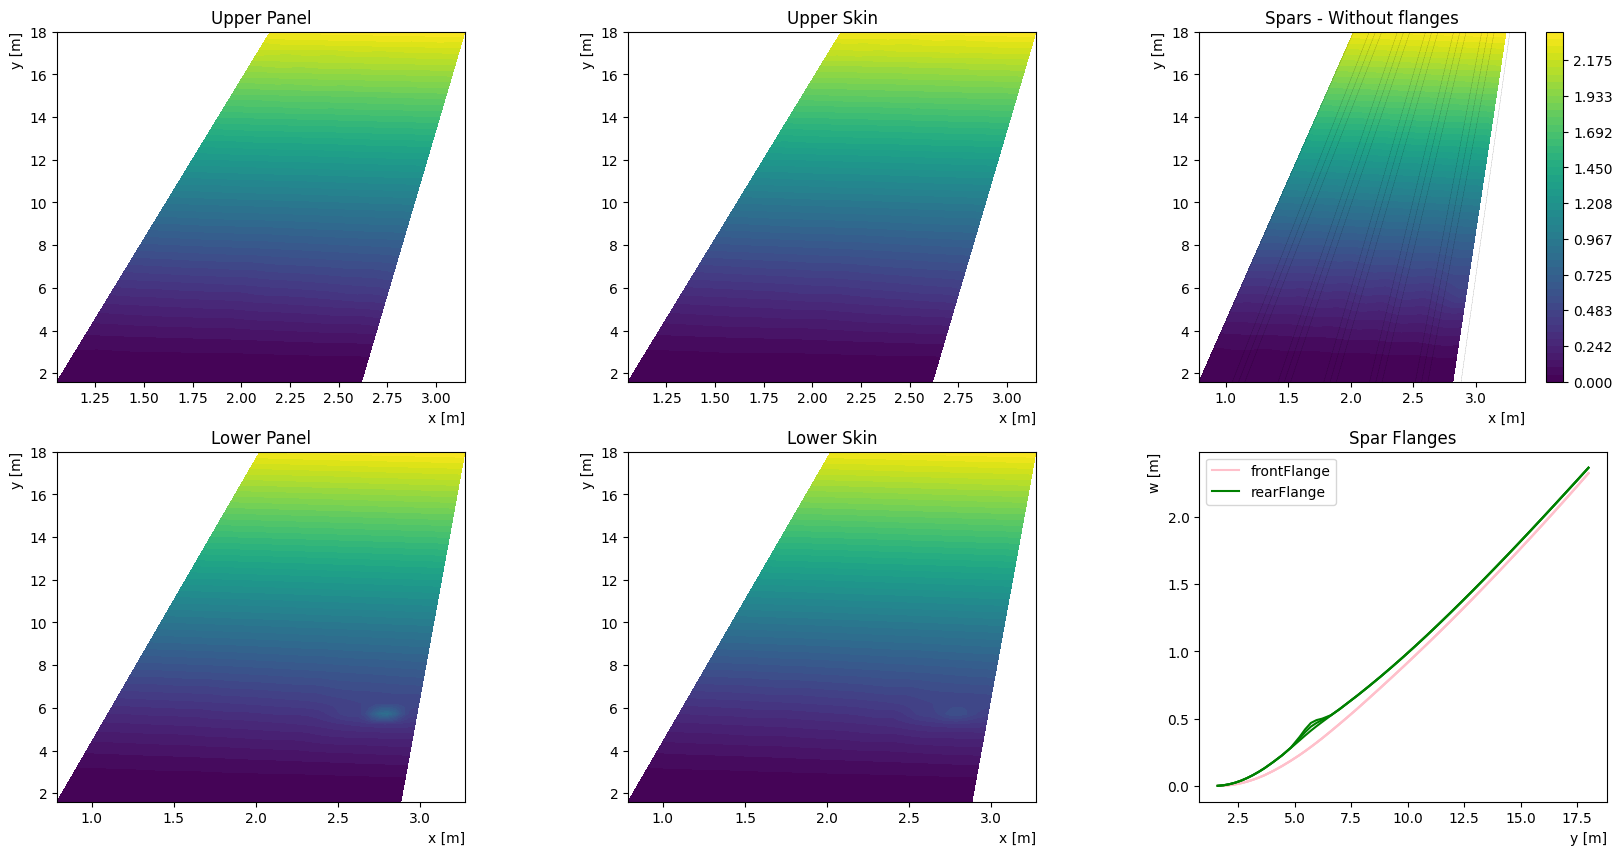

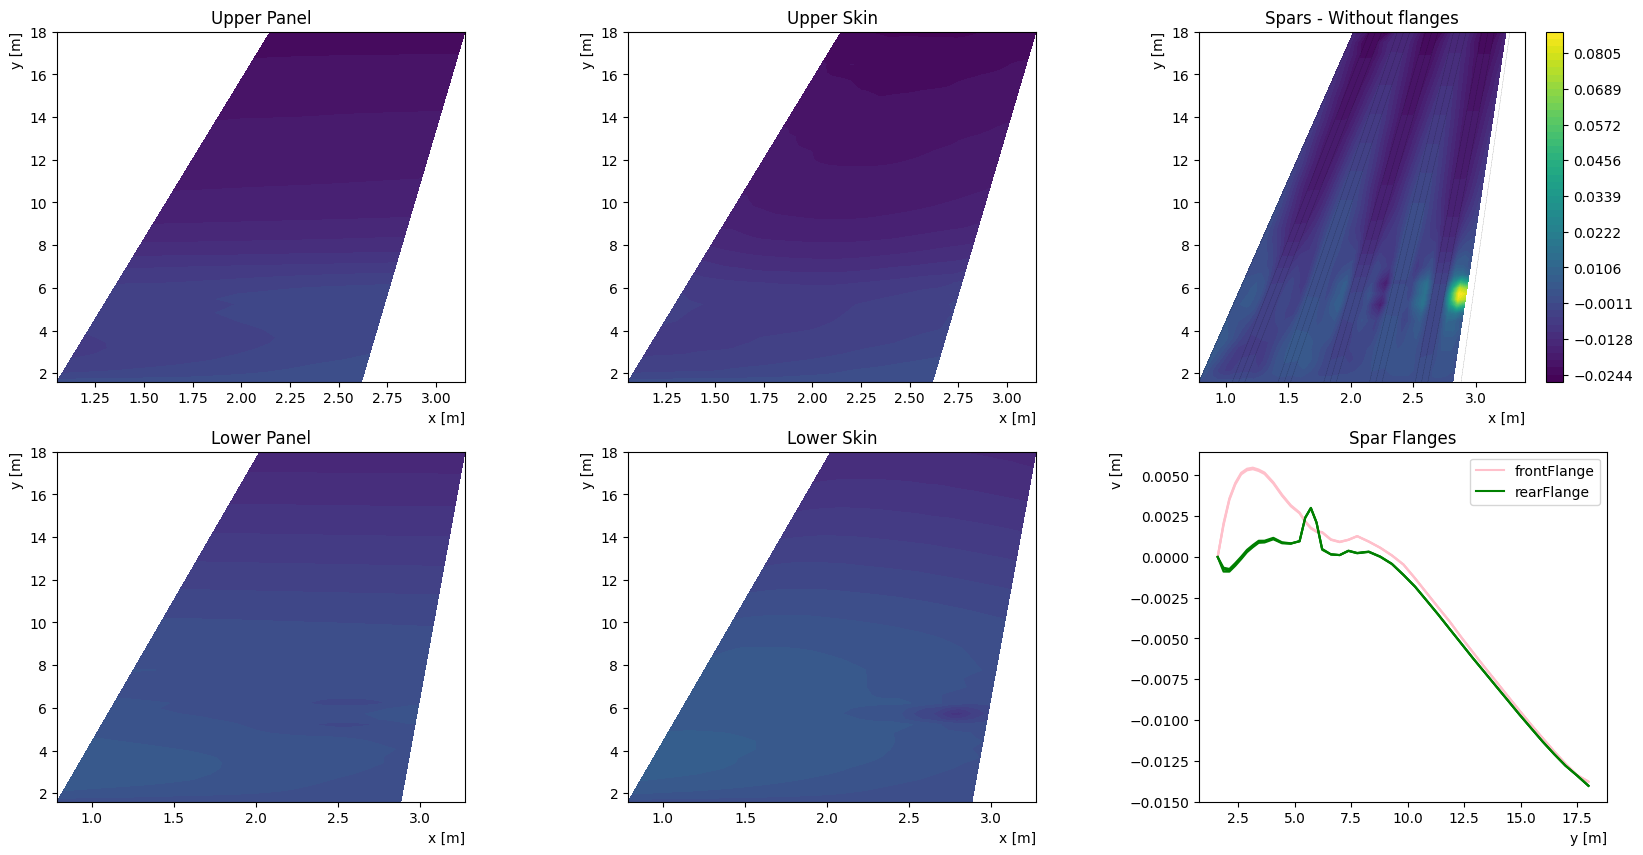

In [6]:
'''Standard deflection plots to check the solution's quality'''
wfig = bl.plot_block(sol['w'], "w", meshOut, csts)
vfig = bl.plot_block(sol['v'], "v", meshOut, csts)

# Post Processor - internal forces and margins for every failure mode

In [47]:
'''COPYPASTE THIS TO blocks.py ONCE DONE!!!'''
def stress_block(defl:ty.Dict[str, nt.NDArray[np.float64]], meshOuts:ty.Dict[str,object], 
                         codes:ty.Dict[str,str], sizerVals:ty.Dict[str,str], consts:ty.Dict[str,object]):
    rfl, din = tuple(consts[k] for k in ['RIB_FLANGE', 'DIN'])
    tsp, tsk, trb, tpl = tuple(sizerVals[k] for k in ['tspar', 'tskin', 'trib', 'tpan'])
    KC0, M, N, x, y, z, mesh, up, ids, pts = tuple(meshOuts[k] for k in ['KC0', 'M', 'N', 'x', 'y', 'z', 'mesh', 'up', 'ids', 'pts'])
    eleDict, KGv, KGr, KGc, ncoords_flatten = tuple(meshOuts[k] for k in ['elements', 'KGv', 'KGr', 'KGc', 'ncoords_flatten'])
    fi = np.zeros(meshOuts["N"])
    u, bu, bk, Kuu = tuple(defl[k] for k in ["u", "bu", "bk", "KC0uu"])

    '''INTERNAL LOADS'''
    #only for quads and beams as of now - that's all we are using
    sigma_most = {'quad':{codes["skin"]:[], codes["panelRib"]:[], codes["panelPlate"]:[], codes["spar"]:[]},
                'beam':{codes["rail"]:[], codes["panelFlange"]:[]}}
    tau_most = {'quad':{codes["skin"]:[], codes["panelRib"]:[], codes["panelPlate"]:[], codes["spar"]:[]},
                'beam':{codes["rail"]:[], codes["panelFlange"]:[]}}
    sorted_eles = {'quad':{codes["skin"]:[], codes["panelRib"]:[], codes["panelPlate"]:[], codes["spar"]:[]},
                'beam':{codes["rail"]:[], codes["panelFlange"]:[]}}
    for quad in eleDict["quad"]:
        # NOTE update affects the Quad4RProbe class attribute ue
        quad.update_probe_xe(ncoords_flatten)
        quad.update_probe_ue(u)
        quad.update_KG(KGr, KGc, KGv, quad.shellprop)
        quad.update_probe_finte(quad.shellprop)
        quad.update_fint(fi, quad.shellprop)

        "stresses"
        if quad.eleid == codes["skin"]:
            pass

        elif quad.eleid == codes["panelRib"]:
            pass

        elif quad.eleid == codes["panelPlate"]:
            pass

        elif quad.eleid == codes["spar"]:
            pass

        else: raise NotImplementedError(f"A quad element of eleid {quad.eleid} not accounted for in post-processing!")

    for beam in eleDict["beam"]:
        beam.update_probe_xe(ncoords_flatten)
        beam.update_probe_ue(u)
        beam.update_KG(KGr, KGc, KGv, beam.beamprop, 0) #here only values change
        beam.update_probe_finte(beam.beamprop)
        beam.update_fint(fi, beam.beamprop) 

        "stresses"
        Fx1, Fy1, Fz1, Mx1, My1, Mz1 = beam.probe.finte[:6]

        A, J, Iyy, Izz = beam.beamprop.A, beam.beamprop.J, beam.beamprop.Iyy, beam.beamprop.Izz 

        if beam.eleid == codes["rail"]:
            #normal stress
            sigma_most["beam"][codes["rail"]].append(abs(Fx1)/A+din/2*np.sqrt((Mz1/Izz)**2+(My1/Iyy)**2))
                                                     
            #shear stress - we have to run a maximalisation problem for every node
            radius_fun = lambda xe:xe[0]**2+xe[1]**2
            rad_constr = opt.NonlinearConstraint(radius_fun, -1e-6, 1.00001) #TODO: add actual jacobian
            #negative to use minimise
            shearsq_fun1 = lambda xe: -(Mx1*xe[1]/J+Fy1/3/Izz*(din**2/4-xe[0]**2))**2-(Mx1*xe[0]/J+Fz1/3/Iyy*(din**2/4-xe[1]**2))**2
            shearsq1 = opt.minimize(shearsq_fun1, np.array([0,0]), constraints=[rad_constr],
                                    method="Cobyla")
            print(shearsq1)
            tau_most["beam"][codes["rail"]].append(np.sqrt(-shearsq1.fun)) #back to actual shear stress

            #saving the element in a matching format
            sorted_eles["beam"][codes["rail"]].append(beam)

        elif beam.eleid == codes["panelFlange"]:
            #most constraining normal stress in when bending stresses are in the same direction as axial stress
            #! For isotropic materials only!
            sigma_most["beam"][codes["panelFlange"]].append(abs(Fx1)/A+(abs(My1)/Iyy*trb/2+abs(Mz1)/Izz*rfl/2))

            #most constraining shear stress - either one of the sides with torsion of the middle
            def tau_most_at_node(Mx, Fy, Fz):
                tau_Mx = abs(Mx)*(3+1.8*trb/rfl)/rfl/trb**2 #directions don't matter, we can get all combinations
                tau_Fz = abs(Fz)*trb**2/8/Iyy
                tau_Fy = abs(Fy)*rfl**2/8/Izz
                return max(tau_Mx+tau_Fz, tau_Mx+tau_Fy, np.sqrt(tau_Fy**2+tau_Fz**2))
            tau_most["beam"][codes["panelFlange"]].append(tau_most_at_node(Mx1, Fy1, Fz1))

            #saving the element in a matching format
            sorted_eles["beam"][codes["panelFlange"]].append(beam)

        else: raise NotImplementedError(f"A beam element of eleid {quad.eleid} not accounted for in post-processing!")
          
    fi[bk] = 0 #to avoid internal force at clamps which can be latge and are weirdly defined

    return sorted_eles, tau_most, sigma_most, fi

def eigen_analysis_block(defl:ty.Dict[str, nt.NDArray[np.float64]], meshOuts:ty.Dict[str,object], 
                         codes:ty.Dict[str,str], sizerVals:ty.Dict[str,str], consts:ty.Dict[str,object]):
    rfl, din = tuple(consts[k] for k in ['RIB_FLANGE', 'DIN'])
    tsp, tsk, trb, tpl = tuple(sizerVals[k] for k in ['tspar', 'tskin', 'trib', 'tpan'])
    KC0, M, N, x, y, z, mesh, up, ids, pts = tuple(meshOuts[k] for k in ['KC0', 'M', 'N', 'x', 'y', 'z', 'mesh', 'up', 'ids', 'pts'])
    eleDict, KGv, KGr, KGc, ncoords_flatten = tuple(meshOuts[k] for k in ['elements', 'KGv', 'KGr', 'KGc', 'ncoords_flatten'])
    u, bu, bk, Kuu = tuple(defl[k] for k in ["u", "bu", "bk", "KC0uu"])

    '''BUCKLING ANALYSIS'''
    KG = ss.coo_matrix((KGv, (KGr, KGc)), shape=(N, N)).tocsc()
    KGuu = KG[bu, :][:, bu]
    num_eig_lb = 4 #TODO: for now
    eigvecs = np.zeros((N, num_eig_lb))
    eigvals, eigvecsu = ssl.eigsh(A=KGuu, k=num_eig_lb, which="SM", M=Kuu, tol=1e-15, sigma=1., mode="cayley")
    eigvals = -1./eigvals
    eigvecs[bu] = eigvecsu
    load_mult = eigvals[0] #TODO from what it seems to me has to be strictly greater than one

    '''EIGENFREQUENCY ANALYSIS'''
    Muu = M[bu, :][:, bu]
    num_eig=6 #TODO: for now
    eigvecsO = np.zeros((N, num_eig))
    eigvalsO, eigvecsuO = ssl.eigsh(A=Kuu, M=Muu, sigma=-1., which='LM',
            k=num_eig, tol=1e-5)
    eigvecsO[bu] = eigvecsuO
    omegan = eigvalsO**0.5

    return KG, KGuu, load_mult, eigvecs, eigvals, omegan

'A WRAPPER FUNCTION FOR ALL POST-PROCESSING'    
def post_processor_block(defl:ty.Dict[str, nt.NDArray[np.float64]], meshOuts:ty.Dict[str,object], 
                         codes:ty.Dict[str,str], sizerVals:ty.Dict[str,str], consts:ty.Dict[str,object]):
    
    sorted_eles, tau_most, sigma_most, fi = stress_block(defl, meshOuts, codes, sizerVals, consts)
    KG, KGuu, load_mult, eigvecs, eigvals, omegan = eigen_analysis_block(defl, meshOuts, codes, sizerVals, consts)

    return {"elements":sorted_eles, "fi":fi, "KG":KG, "KGuu":KGuu, "load_mult":load_mult, "eigvecs":eigvecs, "eigvals":eigvals, "omegan":omegan,
            "sigma":sigma_most, "tau":tau_most}

## Stress

Here be code just for stress sub-block testing

In [48]:
sorted_eles, tau_most, sigma_most, fi = stress_block(sol, meshOut, cst.CODES, cst.INTIAL, cst.CONSTS)


 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -1.6435025874519186e+18
       x: [ 1.000e+00 -1.000e-04]
    nfev: 24
   maxcv: 1.9999873979159588e-08
 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -4.8379484673134445e+17
       x: [ 1.000e+00  8.765e-04]
    nfev: 27
   maxcv: 1.999999987845058e-08
 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -3.3864255656185852e+16
       x: [ 1.000e+00  9.998e-05]
    nfev: 27
   maxcv: 1.99986527338325e-08
 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -2.3402116864539846e+17
       x: [ 1.000e+00  1.000e-04]
    nfev: 26
   maxcv: 2.000036047888898e-08
 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -2.7301542545885496e+18
       x: [ 9.995e-01 -3.105e-02]
    nfev: 30
   maxcv: 2.0003912970523174e-08
 message: Optimization terminated successfully.
 success: T

In [49]:
for r in sorted_eles["beam"][cst.CODES["rail"]]:
    if not np.isclose(np.asanyarray(r.probe.finte).sum(), 0):
        print(r.probe.finte)

In [50]:
import pyvista
pyvista.set_plot_theme('document')
pyvista.set_jupyter_backend('trame')
pyvista.global_theme.window_size = [600, 400]
pyvista.global_theme.axes.show = True
pyvista.global_theme.anti_aliasing = 'fxaa'
pyvista.global_theme.show_scalar_bar = True

In [51]:
print(f"sigma rail: max: {max(sigma_most["beam"][cst.CODES["rail"]])}, min:{min(sigma_most["beam"][cst.CODES["rail"]])}")
print(f"tau rail: max: {max(tau_most["beam"][cst.CODES["rail"]])}, min:{min(tau_most["beam"][cst.CODES["rail"]])}")
print(f"sigma flange: max: {max(sigma_most["beam"][cst.CODES["panelFlange"]])}, min:{min(sigma_most["beam"][cst.CODES["panelFlange"]])}")
print(f"tau flange: max: {max(tau_most["beam"][cst.CODES["panelFlange"]])}, min:{min(tau_most["beam"][cst.CODES["panelFlange"]])}")

sigma rail: max: 0.0, min:0.0
tau rail: max: 22800140132.80294, min:8304070.541381893
sigma flange: max: 0.0, min:0.0
tau flange: max: 0.0, min:0.0


In [55]:
import pyvista as pv

edges = []
sigmas = []
taus = []
sigma_max = max(sigma_most["beam"][cst.CODES["rail"]]+sigma_most["beam"][cst.CODES["panelFlange"]])
tau_max = max(tau_most["beam"][cst.CODES["rail"]]+tau_most["beam"][cst.CODES["panelFlange"]])
tau_argmax = np.array(tau_most["beam"][cst.CODES["rail"]]+tau_most["beam"][cst.CODES["panelFlange"]]).argmax()
print(f"Sigma_max: {sigma_max}; Tau_max: {tau_max}")

for ele, sgm, tau in zip(sorted_eles["beam"][cst.CODES["rail"]]+sorted_eles["beam"][cst.CODES["panelFlange"]],
                         sigma_most["beam"][cst.CODES["rail"]]+sigma_most["beam"][cst.CODES["panelFlange"]],
                         tau_most["beam"][cst.CODES["rail"]]+tau_most["beam"][cst.CODES["panelFlange"]]):
    ncoords, nid_pos, x,y,z = (meshOut[k] for k in ['ncoords', 'nid_pos', 'x', 'y', 'z'])
    edges.append([nid_pos[ele.n1], nid_pos[ele.n2]])
    sigmas.append((1-sgm/sigma_max))
    taus.append(tau)
    if np.isclose(tau, tau_max):
        print(x[nid_pos[ele.n1]], y[nid_pos[ele.n1]], z[nid_pos[ele.n1]])
        print(x[nid_pos[ele.n2]], y[nid_pos[ele.n2]], z[nid_pos[ele.n2]])
    
padding = np.empty(len(edges), int) * 2
padding[:] = 2
edges_w_padding = np.vstack((padding, np.array(edges).T)).T
edges_w_padding

meshpv = pv.PolyData(ncoords, edges_w_padding)
colors = np.nan_to_num(taus)
print(colors)
line_width = np.ones(len(edges))
colors[tau_argmax] = 1
meshpv.plot(scalars=taus,
            render_lines_as_tubes=True,
    style='wireframe',
    line_width=10,
    cmap='jet',
    show_scalar_bar=False,
    background='w',)

Sigma_max: 0.0; Tau_max: 22800140132.80294
2.2152057557148366 17.49101725 2.3117336850935972
2.2492088715524226 18.0 2.3689029999999995
[1.28199165e+09 6.95553626e+08 1.84022432e+08 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]


C:\Users\marri\AppData\Local\Temp\ipykernel_2700\3584623522.py:16: RuntimeWarning: invalid value encountered in scalar divide
  sigmas.append((1-sgm/sigma_max))


Widget(value='<iframe src="http://localhost:63669/index.html?ui=P_0x12a445b4e30_20&reconnect=auto" class="pyvi…

In [58]:
import pyvista as pv

edges = []
sigmas = []
taus = []
sigma_max = max(sigma_most["beam"][cst.CODES["rail"]])
tau_max = max(tau_most["beam"][cst.CODES["rail"]])
tau_argmax = np.array(tau_most["beam"][cst.CODES["rail"]]).argmax()
print(f"Sigma_max: {sigma_max}; Tau_max: {tau_max}")

for ele, sgm, tau in zip(sorted_eles["beam"][cst.CODES["rail"]],
                         sigma_most["beam"][cst.CODES["rail"]],
                         tau_most["beam"][cst.CODES["rail"]]):
    ncoords, nid_pos, x,y,z = (meshOut[k] for k in ['ncoords', 'nid_pos', 'x', 'y', 'z'])
    edges.append([nid_pos[ele.n1], nid_pos[ele.n2]])
    sigmas.append((1-sgm/sigma_max))
    taus.append(tau)
    if np.isclose(tau, tau_max):
        print(x[nid_pos[ele.n1]], y[nid_pos[ele.n1]], z[nid_pos[ele.n1]])
        print(x[nid_pos[ele.n2]], y[nid_pos[ele.n2]], z[nid_pos[ele.n2]])
    
padding = np.empty(len(edges), int) * 2
padding[:] = 2
edges_w_padding = np.vstack((padding, np.array(edges).T)).T
edges_w_padding

meshpv = pv.PolyData(ncoords, edges_w_padding)
colors = np.nan_to_num(taus)
print(colors)
line_width = np.ones(len(edges))
colors[tau_argmax] = 1
meshpv.plot(scalars=taus,
            render_lines_as_tubes=True,
    style='wireframe',
    line_width=10,
    cmap='jet',
    show_scalar_bar=True,
    background='w',)

Sigma_max: 0.0; Tau_max: 22800140132.80294
2.2152057557148366 17.49101725 2.3117336850935972
2.2492088715524226 18.0 2.3689029999999995
[1.28199165e+09 6.95553626e+08 1.84022432e+08 4.83757345e+08
 1.65231784e+09 1.21324549e+09 3.66859879e+09 3.33448583e+09
 3.36786046e+09 2.85771330e+09 4.85304516e+09 4.93691049e+09
 2.07273932e+08 1.08517846e+09 3.54313076e+09 2.96499081e+09
 2.78407881e+09 3.31303655e+09 8.05336261e+08 1.10570196e+09
 3.36090616e+09 2.69757096e+09 5.72658563e+08 1.06174429e+09
 5.12841886e+08 6.90701506e+08 2.11932867e+08 3.68101411e+08
 3.65255952e+08 1.21748459e+08 1.82702345e+08 7.93719838e+07
 9.80922251e+07 9.26481522e+07 4.52305216e+07 1.90011883e+08
 2.30683571e+08 2.79489080e+08 1.61021245e+09 2.90642393e+09
 3.79755180e+09 3.21010823e+09 1.68329845e+09 1.18231588e+09
 3.48421426e+09 3.21858601e+09 1.77057367e+09 1.82920149e+09
 4.95950261e+09 3.76534174e+09 2.39498632e+09 3.31826660e+09
 1.41702169e+09 1.12736709e+09 1.29617717e+09 1.15679592e+09
 1.1784938

C:\Users\marri\AppData\Local\Temp\ipykernel_2700\3321686191.py:16: RuntimeWarning: invalid value encountered in scalar divide
  sigmas.append((1-sgm/sigma_max))


Widget(value='<iframe src="http://localhost:63669/index.html?ui=P_0x12a46067d70_22&reconnect=auto" class="pyvi…

## full tests

In [ ]:
ppd = post_processor_block(sol, meshOut)


: 

[0.29365257 0.29978733 0.30149854 0.3019832  0.30430136 0.30582808]
5.520960503043587e-06
[0.54189719 0.54752839 0.54908883 0.54952998 0.55163517 0.55301726]


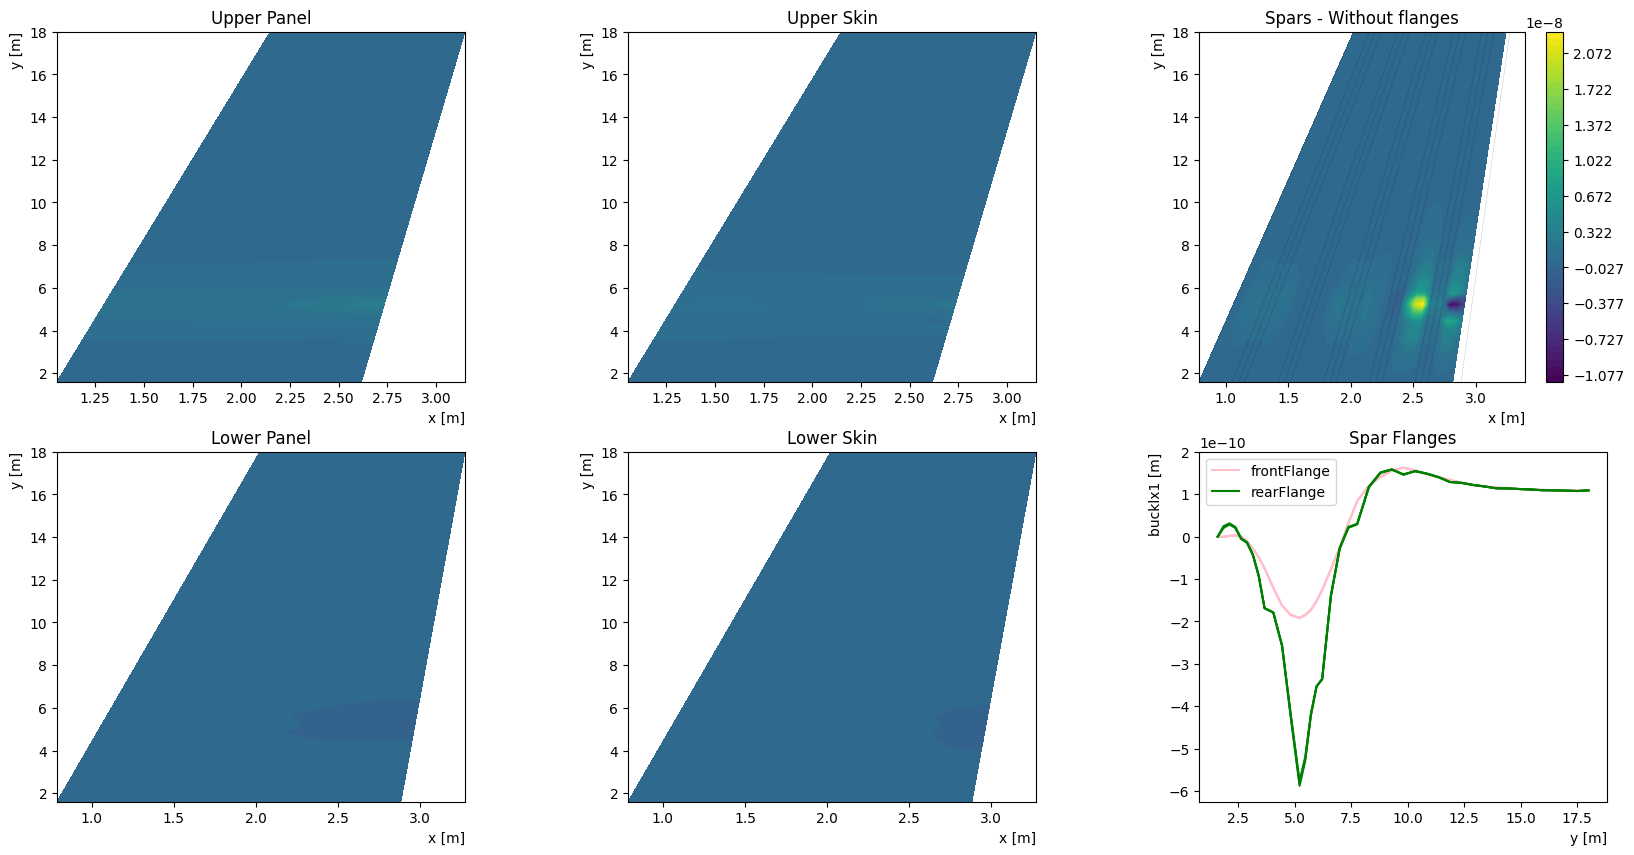

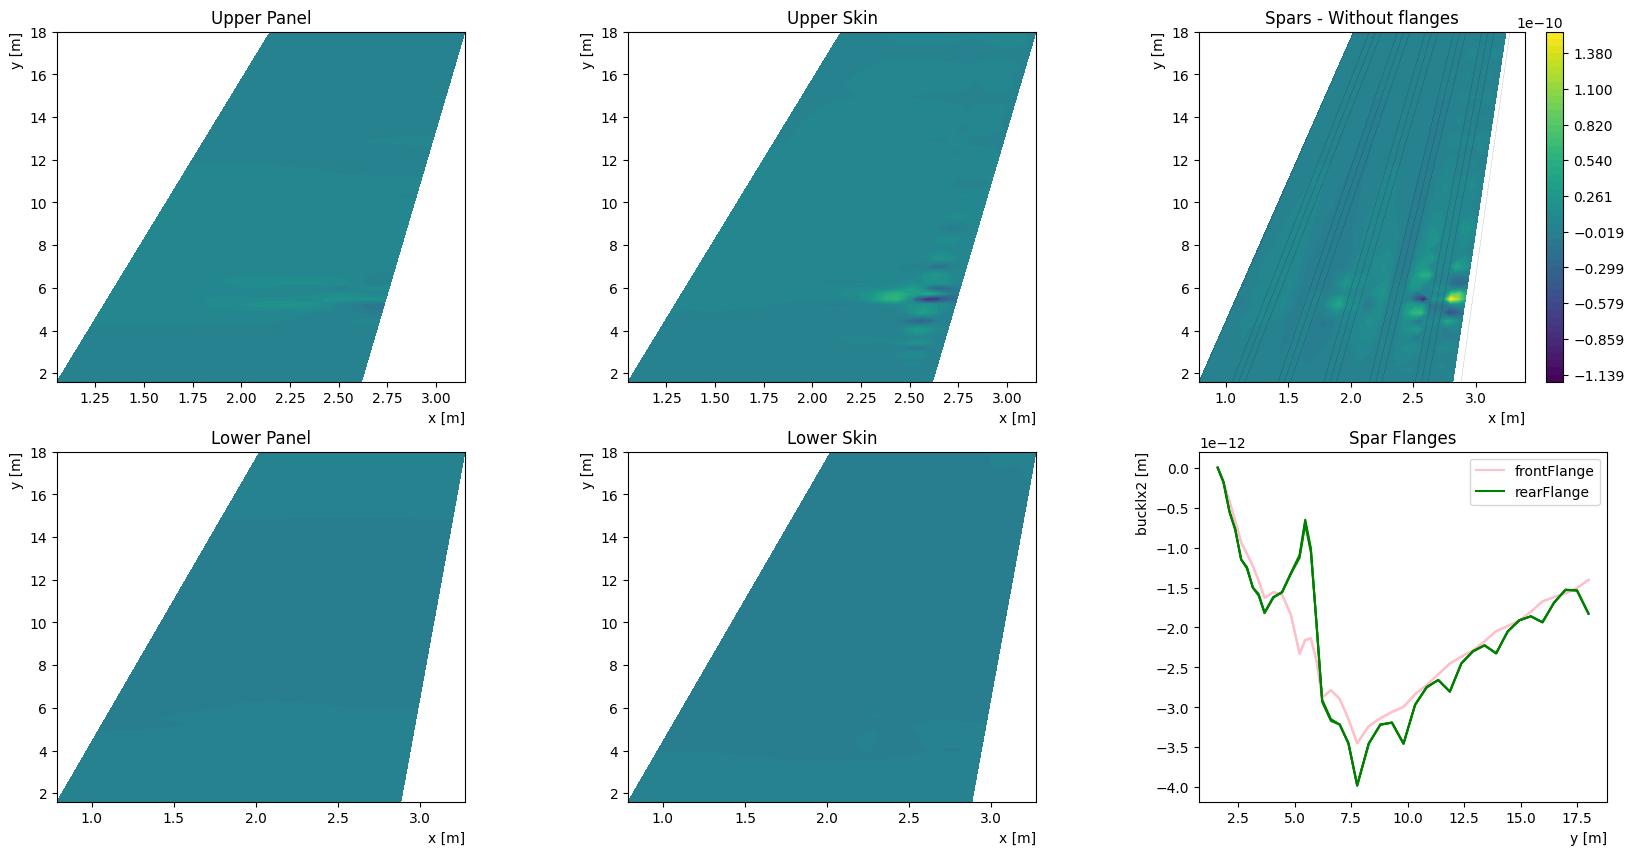

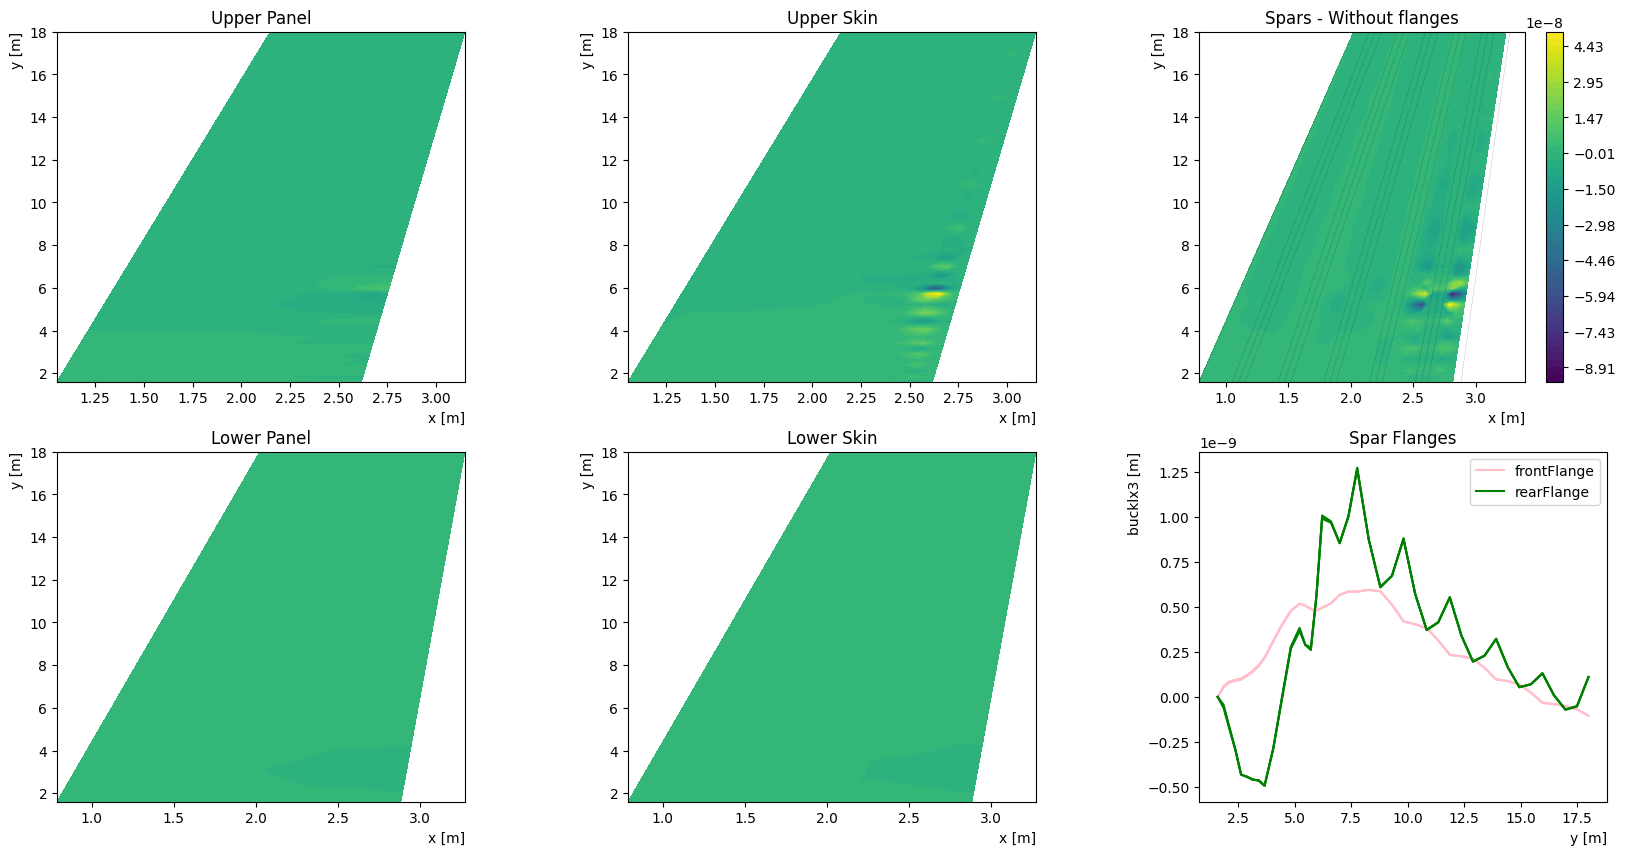

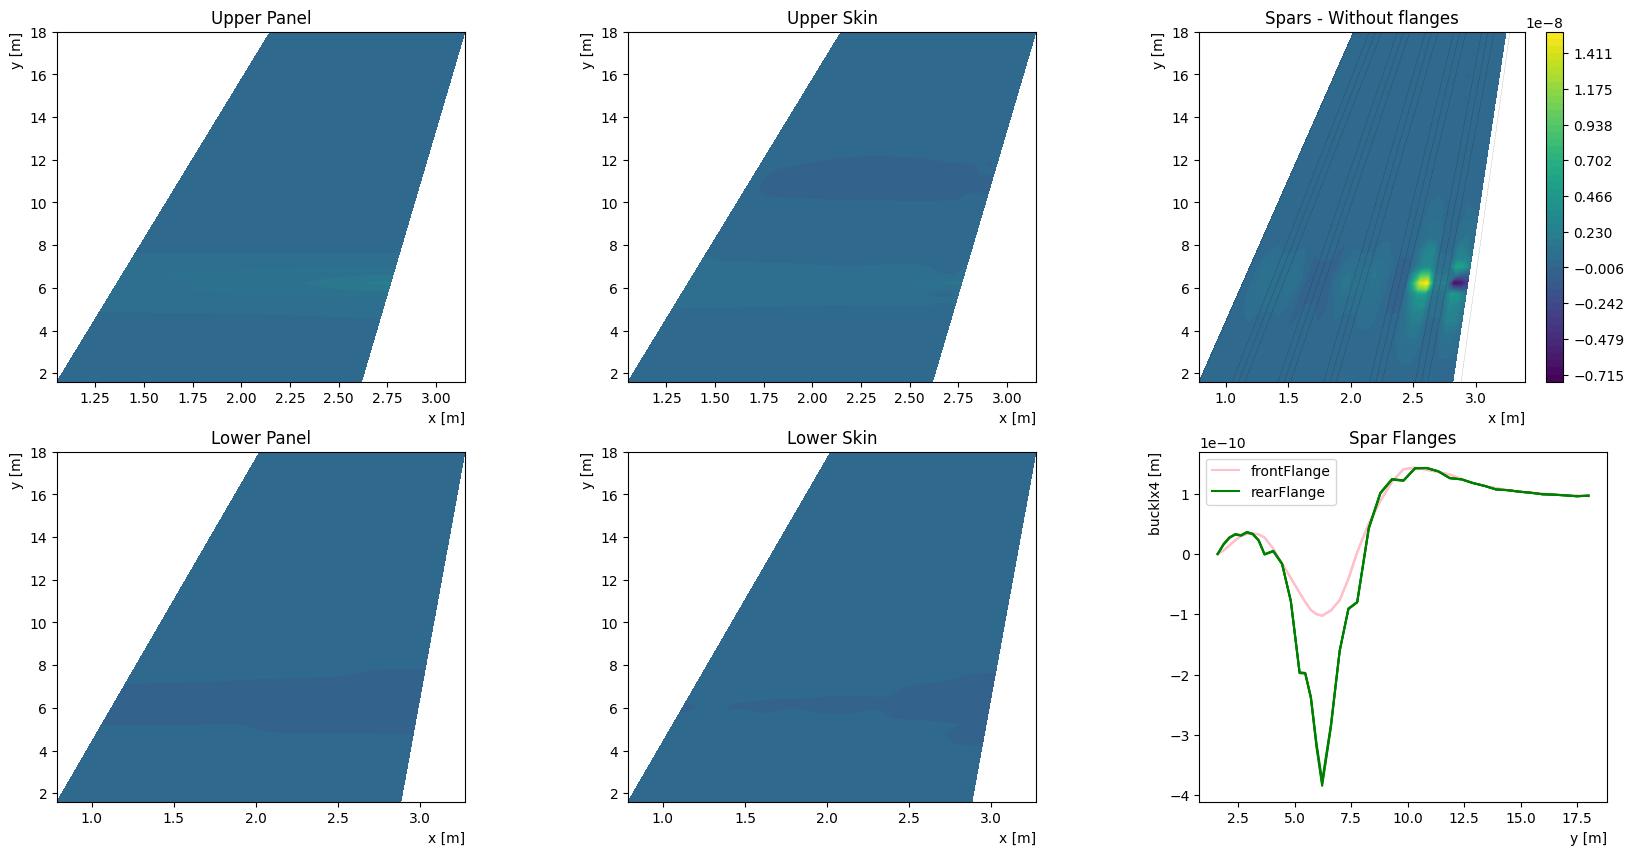

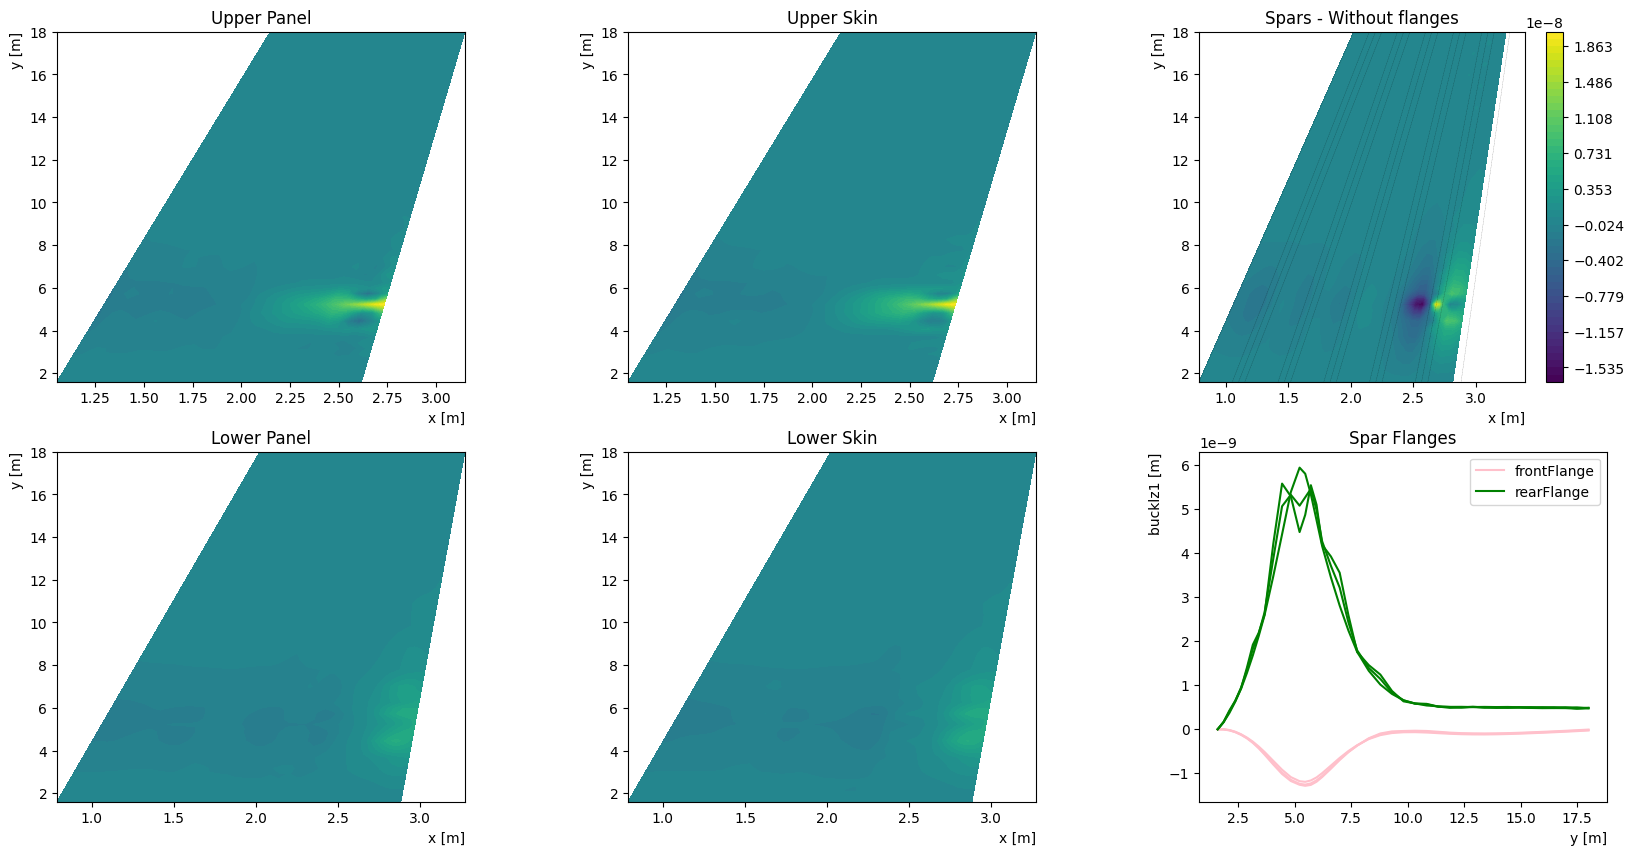

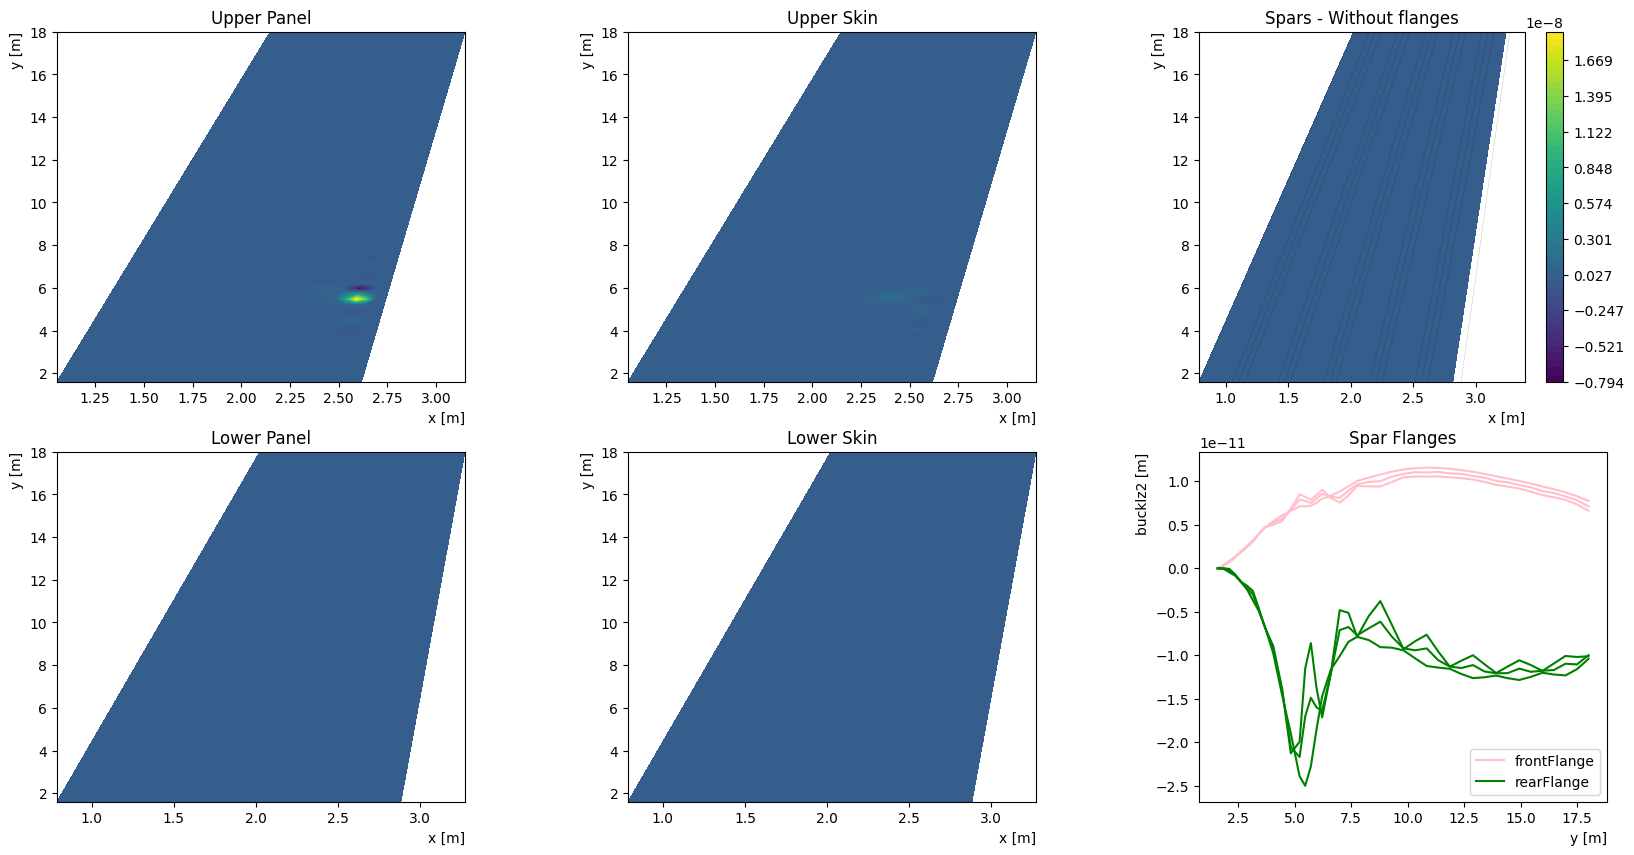

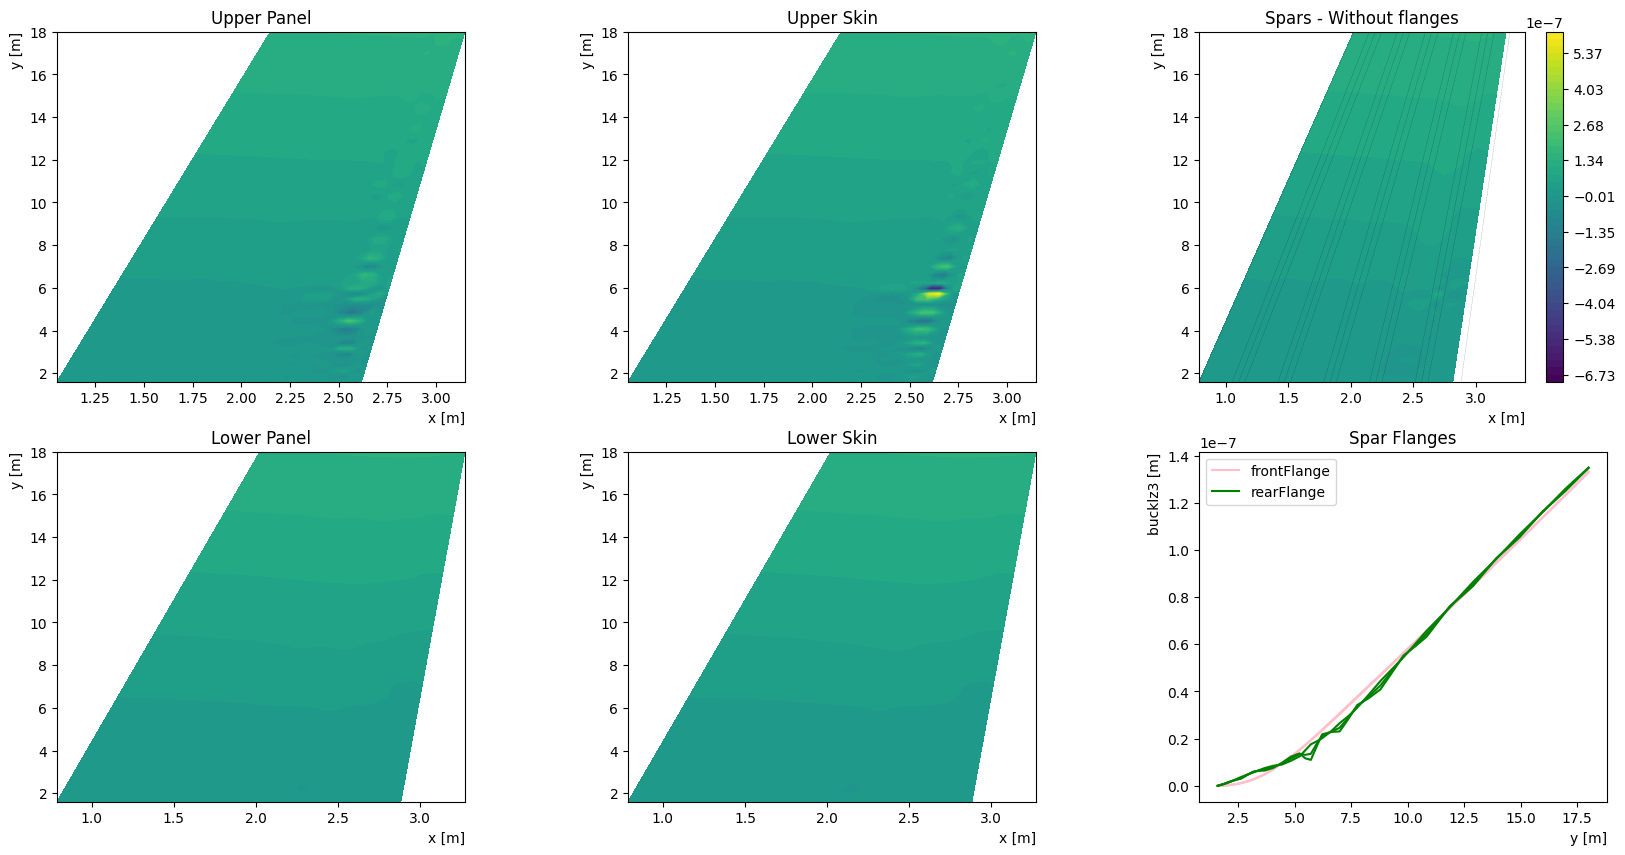

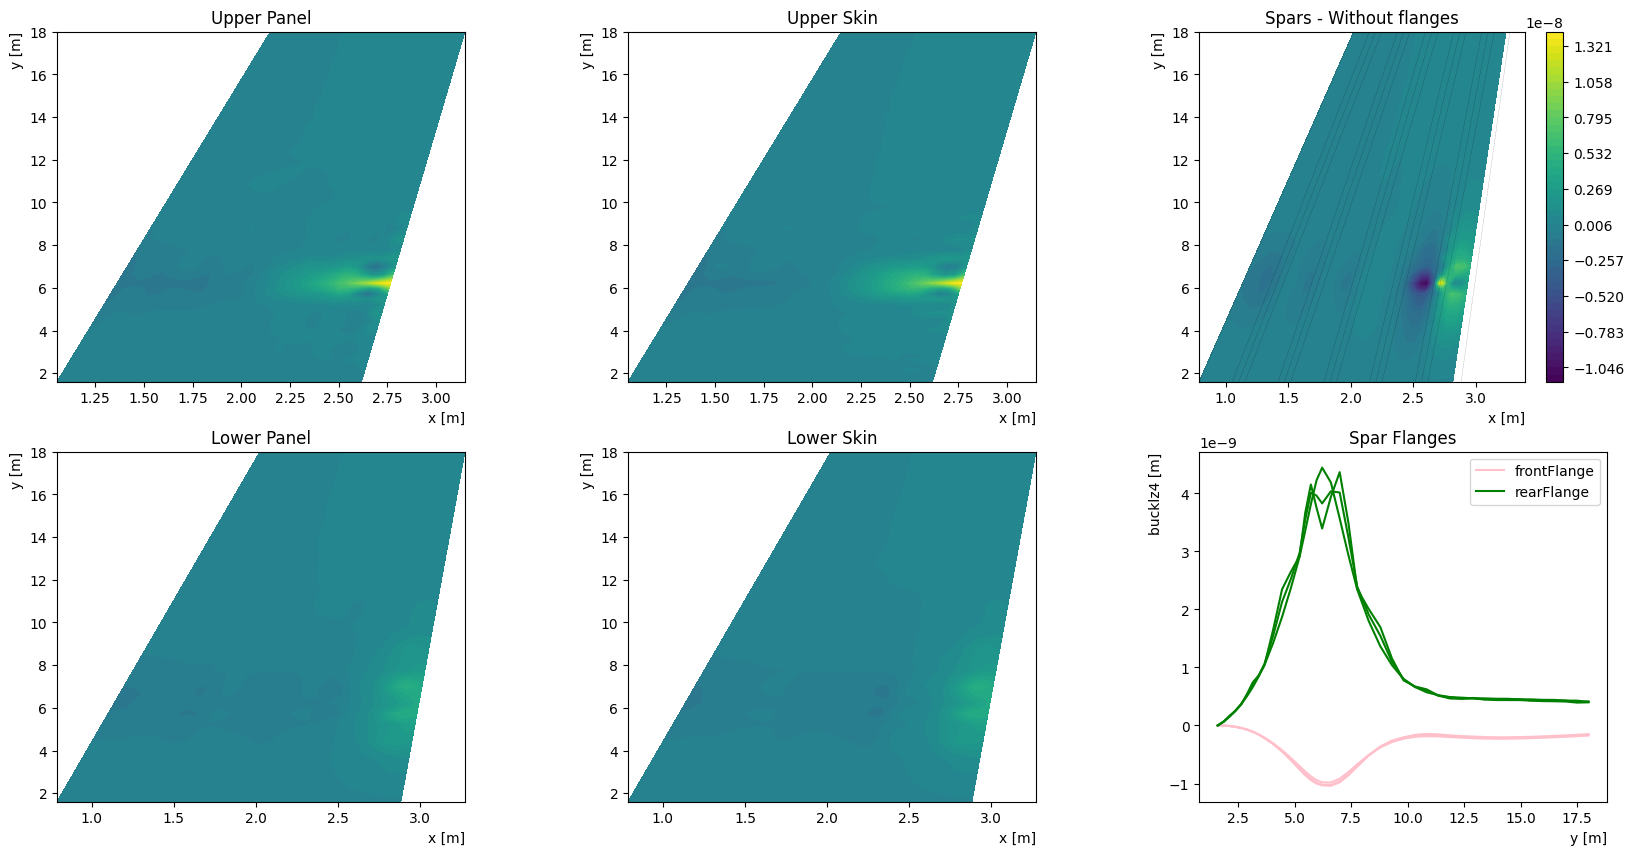

In [15]:
# bl.plot_block(ppd["fi"][0::pf3.DOF], "Fi_x", meshOut, cst.CONSTS, "N")
# bl.plot_block(ppd["fi"][1::pf3.DOF], "Fi_y", meshOut, cst.CONSTS, "N")
# bl.plot_block(ppd["fi"][2::pf3.DOF], "Fi_z", meshOut, cst.CONSTS, "N")
# bl.plot_block(ppd["fi"][3::pf3.DOF], "Mi_x", meshOut, cst.CONSTS, "N")
# bl.plot_block(ppd["fi"][4::pf3.DOF], "Mi_y", meshOut, cst.CONSTS, "N")
# bl.plot_block(ppd["fi"][5::pf3.DOF], "Mi_z", meshOut, cst.CONSTS, "N")
bl.plot_block(ppd["eigvecs"][0::pf3.DOF, 0], "bucklx1", meshOut, cst.CONSTS)
bl.plot_block(ppd["eigvecs"][0::pf3.DOF, 1], "bucklx2", meshOut, cst.CONSTS)
bl.plot_block(ppd["eigvecs"][0::pf3.DOF, 2], "bucklx3", meshOut, cst.CONSTS)
bl.plot_block(ppd["eigvecs"][0::pf3.DOF, 3], "bucklx4", meshOut, cst.CONSTS)
bl.plot_block(ppd["eigvecs"][2::pf3.DOF, 0], "bucklz1", meshOut, cst.CONSTS)
bl.plot_block(ppd["eigvecs"][2::pf3.DOF, 1], "bucklz2", meshOut, cst.CONSTS)
bl.plot_block(ppd["eigvecs"][2::pf3.DOF, 2], "bucklz3", meshOut, cst.CONSTS)
bl.plot_block(ppd["eigvecs"][2::pf3.DOF, 3], "bucklz4", meshOut, cst.CONSTS)
print(ppd["eigvals"])
print(ppd["load_mult"])
print(ppd["omegan"])